In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import logging
from eden.util import configure_logging
configure_logging(logging.getLogger(), verbosity=2)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

In [2]:
import numpy as np

In [3]:
import regex as re
# identify exact occurrence of user defined sequence in pos seqs
def col_red(text):
    return "\x1b[31;1m"+str(text)+"\x1b[0m"
def col_green(text):
    return "\x1b[32;1m"+str(text)+"\x1b[0m"
def col_yellow(text):
    return "\x1b[33;1m"+str(text)+"\x1b[0m"
def col_blue(text):
    return "\x1b[34;1m"+str(text)+"\x1b[0m"
def col_magenta(text):
    return "\x1b[35;1m"+str(text)+"\x1b[0m"
def col_cyan(text):
    return "\x1b[36;1m"+str(text)+"\x1b[0m"


def split_occurrences(needle, haystack, no_header=True, n_max=200):
    i = 0
    for h,s in haystack:
        delim=col_yellow(needle)
        #delim=' '
        sp = re.split(needle, s, overlapped=True)
        counts = len(sp)-1
        if counts != 0:
            i += 1
            if no_header is False:
                print col_green(counts), col_cyan(h)
            seq = delim.join(sp)
            print seq
        if i > n_max:
            break

In [4]:
import GArDen.interfaces as garden
from GArDen.convert.sequence import SeqToPathGraph
from GArDen.transform.rna_structure import PathGraphToRNAPlfold

remap={'A0':'A','C0':'C','G0':'G','U0':'E','T0':'E',
       'A1':'V','C1':'S','G1':'Y','U1':'D','T1':'D'}

def remap_with_structure(pos_seqs, remap=remap):
    graphs = garden.transform(pos_seqs, program=SeqToPathGraph())
    graphs = garden.transform(graphs, program=PathGraphToRNAPlfold(max_num_edges=2,
                                                                   window_size=200,
                                                                   max_bp_span=100,
                                                                   hard_threshold=.5,
                                                                   avg_bp_prob_cutoff=.01))
    for graph in graphs:
        paireds = [graph.node[u]['label']+str(int(graph.node[u].get('paired',False))) for u in graph.nodes()]
        paireds = [remap[c] for c in paireds]
        seq = ''.join(paireds)
        yield ('ID',seq)
alphabet = 'protein'
color_scheme = 'chemistry'

In [5]:
def remap_with_structure(pos_seqs):
    for seq in pos_seqs:
        yield seq
alphabet = 'rna'
color_scheme = 'classic'

In [6]:
def filter_pvalue(iterable, threshold=2, less_than=False):
    for header,seq in iterable:
        val = float(header.split('_')[1])
        if less_than:
            if val < threshold:
                yield (header,seq)
        else:
            if val > threshold:
                yield (header,seq)

In [7]:
def filter_pvalue(iterable, threshold=2, less_than=False):
    for header,seq in iterable:
        val = float(header.split(';')[2])
        if less_than:
            if val < threshold:
                yield (header,seq)
        else:
            if val > threshold:
                yield (header,seq)

In [8]:
dir_name = '/Users/costa/Desktop/BTSync/DATA/RBP/'

In [9]:
!ls  $dir_name

AARS-human_K562_ENCSR825SVO_rep1_unique_ids_extlr60_context0.fa
AARS-human_K562_ENCSR825SVO_rep2_unique_ids_extlr60_context0.fa
AGGF1-human_HepG2_ENCSR543TPH_rep1_unique_ids_extlr60_context0.fa
AGGF1-human_HepG2_ENCSR543TPH_rep2_unique_ids_extlr60_context0.fa
AGGF1-human_K562_ENCSR725ARB_rep1_unique_ids_extlr60_context0.fa
AGGF1-human_K562_ENCSR725ARB_rep2_unique_ids_extlr60_context0.fa
AKAP8L-human_K562_ENCSR206RXT_rep1_unique_ids_extlr60_context0.fa
AKAP8L-human_K562_ENCSR206RXT_rep2_unique_ids_extlr60_context0.fa
AUH-human_HepG2_ENCSR334QFR_rep1_unique_ids_extlr60_context0.fa
AUH-human_HepG2_ENCSR334QFR_rep2_unique_ids_extlr60_context0.fa
AUH-human_K562_ENCSR541QHS_rep1_unique_ids_extlr60_context0.fa
AUH-human_K562_ENCSR541QHS_rep2_unique_ids_extlr60_context0.fa
BCCIP-human_HepG2_ENCSR485QCG_rep1_unique_ids_extlr60_context0.fa
BCCIP-human_HepG2_ENCSR485QCG_rep2_unique_ids_extlr60_context0.fa
BUD13-human_HepG2_ENCSR830BSQ_rep1_unique_ids_extlr60_context0.fa
BUD13-human_HepG2_ENCSR830

# SMoD

In [10]:
# good ones
name = 'HNRNPC-human_HepG2_ENCSR550DVK_rep1_unique_ids_extlr60_context0.fa'
name = 'HNRNPK-human_HepG2_ENCSR828ZID_rep1_unique_ids_extlr60_context0.fa'
name = 'KHDRBS1-human_K562_ENCSR628IDK_rep1_unique_ids_extlr60_context0.fa'
name = 'HNRNPA1-human_HepG2_ENCSR769UEW_rep1_unique_ids_extlr60_context0.fa'
name = 'PCBP2-human_HepG2_ENCSR339FUY_rep2_unique_ids_extlr60_context0.fa' #**
name = 'LIN28B-human_K562_ENCSR970NKP_rep2_unique_ids_extlr60_context0.fa' #difficult motives
name = 'GTF2F1-human_HepG2_ENCSR265ZIS_rep1_unique_ids_extlr60_context0.fa'
name = 'U2AF2-human_HepG2_ENCSR202BFN_rep1_unique_ids_extlr60_context0.fa'
name = 'QKI-human_HepG2_ENCSR570WLM_rep1_unique_ids_extlr60_context0.fa' #**
name = 'RBFOX2-human_HepG2_ENCSR987FTF_rep1_unique_ids_extlr60_context0.fa' #**
name = 'TAF15-human_HepG2_ENCSR841EQA_rep1_unique_ids_extlr60_context0.fa'
name = 'TARDBP-human_K562_ENCSR584TCR_rep1_unique_ids_extlr60_context0.fa' #***
name = 'U2AF2-human_K562_ENCSR893RAV_rep1_unique_ids_extlr60_context0.fa'
pos_fname = dir_name+name

In [11]:
name = 'IGF2BP3-human_HepG2_ENCSR993OLA_rep1_unique_ids_extlr60_context0.fa'
name = 'FMR1-human_K562_ENCSR331VNX_rep1_unique_ids_extlr60_context0.fa' #bad
name = 'TIA1-human_HepG2_ENCSR623VEQ_rep1_unique_ids_extlr60_context0.fa'
name = 'ZRANB2-human_K562_ENCSR663NRA_rep2_unique_ids_extlr60_context0.fa'
name = 'ZNF622-human_K562_ENCSR657TZZ_rep2_unique_ids_extlr60_context0.fa'
name = 'YWHAG-human_K562_ENCSR867ZVK_rep2_unique_ids_extlr60_context0.fa'
name = 'YBX3-human_K562_ENCSR529FKI_rep2_unique_ids_extlr60_context0.fa'
name = 'RBM15-human_HepG2_ENCSR754NDA_rep1_unique_ids_extlr60_context0.fa'#?
name = 'XRCC6-human_K562_ENCSR258QKO_rep1_unique_ids_extlr60_context0.fa'
name = 'SLBP-human_K562_ENCSR483NOP_rep1_unique_ids_extlr60_context0.fa'
name = 'RBM27-human_K562_ENCSR489RJI_rep1_unique_ids_extlr60_context0.fa'
name = 'SRSF1-human_HepG2_ENCSR989VIY_rep1_unique_ids_extlr60_context0.fa'
name = 'SRSF7-human_K562_ENCSR468FSW_rep1_unique_ids_extlr60_context0.fa'
name = 'YBX3-human_K562_ENCSR529FKI_rep1_unique_ids_extlr60_context0.fa'
name = 'ZNF622-human_K562_ENCSR657TZZ_rep2_unique_ids_extlr60_context0.fa'
pos_fname = dir_name+name

In [18]:
complexity=5 #feature resolution
n_clusters=20 # maximal num of motives; tradeoff: if high -> small omogenous motives, if low -> few mixed motives
min_subarray_size = 5
max_subarray_size = 10
p_value = 0.05
regex_th=0.3 # minimum frequency of a nt to be included in the consensus regex 
# merging parameters
similarity_th=0.5
min_score=5
min_freq=0.6
min_cluster_size=10
sample_size=300
#filtering parameters
freq_th=0.02 # minimum frequency of a consensus regex to be displayed
std_th=30 # maximum std of localization of consensus regex within the sequence

In [23]:
desired_size=300
min_diff=desired_size
for th in np.linspace(2.0, 5.5, num=15):
    from eden.converter.fasta import fasta_to_sequence
    pos_seqs = fasta_to_sequence(pos_fname)
    pos_seqs = filter_pvalue(pos_seqs,threshold=th)
    from eden.util import iterator_size
    num = iterator_size(pos_seqs)
    diff = abs(num-desired_size)
    if diff < min_diff:
        min_diff = diff
        min_th = th
    print 'fold_change_th: %.1f  selected seqs:%.6s  diff_to_desired: %.6s'%(th, num , diff)
th = min_th
print 'Selected threshold %.1f' % th

fold_change_th: 2.0  selected seqs:48814  diff_to_desired: 48514
fold_change_th: 2.2  selected seqs:36198  diff_to_desired: 35898
fold_change_th: 2.5  selected seqs:27781  diff_to_desired: 27481
fold_change_th: 2.8  selected seqs:19793  diff_to_desired: 19493
fold_change_th: 3.0  selected seqs:16151  diff_to_desired: 15851
fold_change_th: 3.2  selected seqs:10219  diff_to_desired: 9919
fold_change_th: 3.5  selected seqs:7207  diff_to_desired: 6907
fold_change_th: 3.8  selected seqs:4438  diff_to_desired: 4138
fold_change_th: 4.0  selected seqs:3108  diff_to_desired: 2808
fold_change_th: 4.2  selected seqs:1761  diff_to_desired: 1461
fold_change_th: 4.5  selected seqs:1135  diff_to_desired: 835
fold_change_th: 4.8  selected seqs:633  diff_to_desired: 333
fold_change_th: 5.0  selected seqs:386  diff_to_desired: 86
fold_change_th: 5.2  selected seqs:198  diff_to_desired: 102
fold_change_th: 5.5  selected seqs:125  diff_to_desired: 175
Selected threshold 5.0


In [24]:
%%time
from eden.converter.fasta import fasta_to_sequence
all_seqs = list(fasta_to_sequence(pos_fname))

from eden.converter.fasta import fasta_to_sequence
pos_seqs = fasta_to_sequence(pos_fname)
pos_seqs = filter_pvalue(pos_seqs,threshold=th)
pos_seqs = remap_with_structure(pos_seqs)
pos_seqs=list(pos_seqs)

#neg_seqs = fasta_to_sequence(neg_fname)
from eden.converter.fasta import fasta_to_sequence
neg_seqs = fasta_to_sequence(pos_fname)
neg_seqs = filter_pvalue(neg_seqs,threshold=th)
neg_seqs = remap_with_structure(neg_seqs)
from eden.modifier.seq import seq_to_seq, shuffle_modifier
neg_seqs = seq_to_seq(neg_seqs, modifier=shuffle_modifier, times=2, order=1)
neg_seqs_ord1 = list(neg_seqs)

from eden.converter.fasta import fasta_to_sequence
neg_seqs = fasta_to_sequence(pos_fname)
neg_seqs = filter_pvalue(neg_seqs,threshold=th)
neg_seqs = remap_with_structure(neg_seqs)
from eden.modifier.seq import seq_to_seq, shuffle_modifier
neg_seqs = seq_to_seq(neg_seqs, modifier=shuffle_modifier, times=1, order=2)
neg_seqs_ord2 = list(neg_seqs)

neg_seqs = neg_seqs_ord1 + neg_seqs_ord2

pos_size = len(pos_seqs)
train_pos_seqs = pos_seqs[:pos_size/2]
test_pos_seqs = pos_seqs[pos_size/2:]

neg_size = len(neg_seqs)
train_neg_seqs = neg_seqs[:neg_size/2]
test_neg_seqs = neg_seqs[neg_size/2:]

pos_block_size = pos_size / 16
neg_block_size = neg_size / 16

CPU times: user 4.58 s, sys: 44.5 ms, total: 4.63 s
Wall time: 4.63 s


In [25]:
%%time
from eden.sequence_motif_decomposer import SequenceMotifDecomposer as SMoD
smod=SMoD(complexity=complexity,
          n_clusters=n_clusters,
          min_subarray_size=min_subarray_size,
          max_subarray_size=max_subarray_size,
          pos_block_size=pos_block_size,
          neg_block_size=neg_block_size)
smod = smod.fit(train_pos_seqs, train_neg_seqs)
smod.performance(test_pos_seqs, test_neg_seqs)
motives = smod.select_motives(seqs=pos_seqs,
                              p_value=p_value,
                              similarity_th=similarity_th,
                              min_score=min_score,
                              min_freq=min_freq,
                              min_cluster_size=min_cluster_size,
                              regex_th=regex_th,
                              sample_size=sample_size,
                              freq_th=freq_th,
                              std_th=std_th)

Setup 0.07 secs
Fitting
0 (24, 32769) (2.43 secs) (delta: 2.43)
1 (24, 32769) (2.44 secs) (delta: 0.00)
2 (24, 32769) (2.45 secs) (delta: 0.02)
3 (24, 32769) (2.48 secs) (delta: 0.02)
4 (24, 32769) (2.48 secs) (delta: 0.01)
5 (24, 32769) (2.49 secs) (delta: 0.00)
6 (24, 32769) (2.50 secs) (delta: 0.01)
7 (24, 32769) (2.50 secs) (delta: 0.00)
Setup 0.10 secs
Annotating
0 (1.69 secs) (delta: 1.69)
1 (1.69 secs) (delta: 0.00)
2 (1.72 secs) (delta: 0.03)
3 (1.75 secs) (delta: 0.02)
4 (1.78 secs) (delta: 0.03)
5 (1.81 secs) (delta: 0.02)
6 (1.81 secs) (delta: 0.00)
7 (1.81 secs) (delta: 0.00)
8 (3.43 secs) (delta: 1.62)
9 (3.52 secs) (delta: 0.08)
10 (3.52 secs) (delta: 0.00)
11 (3.52 secs) (delta: 0.00)
12 (3.52 secs) (delta: 0.00)
13 (3.52 secs) (delta: 0.00)
14 (3.56 secs) (delta: 0.04)
15 (3.57 secs) (delta: 0.00)
16 (5.18 secs) (delta: 1.61)
17 (5.25 secs) (delta: 0.06)
18 (5.26 secs) (delta: 0.01)
19 (5.26 secs) (delta: 0.00)
20 (5.26 secs) (delta: 0.00)
21 (5.28 secs) (delta: 0.02)
2

In [29]:
from IPython import display
display.Markdown(data=smod.report(all_seqs, motives, fname='motif'))

Motif id: 3
-  num subarrays: 15
-  consensus sequence: AAGAAGAAGA
-  consensus regex: AAGAAGAAGA
-  num occurrences of regex: 16
-  freq of occurrences of regex: 0.04
-  average location: 49.0 +- 24.0
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_logo_cl_3.png"></p>
<p align="left"><img src="motif_logo_cl_3.png"></p>
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_loc_3.png" style="width: 100%"></p>
<p align="left"><img src="motif_loc_3.png" style="width: 100%"></p>
-  num co-occurences of motif 3 vs 9: 0
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_dist_3_vs_9.png" style="width: 100%"></p>
<p align="left"><img src="motif_dist_3_vs_9.png" style="width: 100%"></p>
____________________________________________________________________________________________________
Motif id: 9
-  num subarrays: 78
-  consensus sequence: UUUUUUUUU
-  consensus regex: U(U|C)UUU(U|C)UUU
-  num occurrences of regex: 11
-  freq of occurrences of regex: 0.03
-  average location: 23.0 +- 15.0
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_logo_cl_9.png"></p>
<p align="left"><img src="motif_logo_cl_9.png"></p>
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_loc_9.png" style="width: 100%"></p>
<p align="left"><img src="motif_loc_9.png" style="width: 100%"></p>
-  num co-occurences of motif 9 vs 3: 0
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/motif_dist_9_vs_3.png" style="width: 100%"></p>
<p align="left"><img src="motif_dist_9_vs_3.png" style="width: 100%"></p>
____________________________________________________________________________________________________

Exact pattern UGGAGCUGG occurs 346 times in 91350 seqs (0.00)


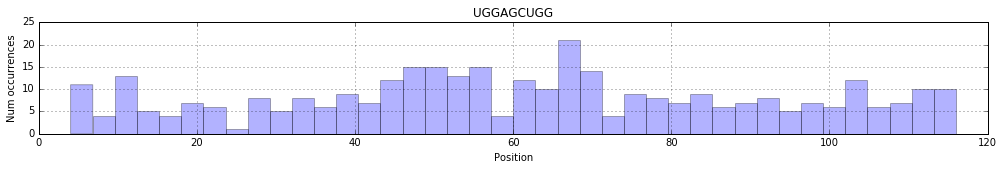

AGGGUUGGGGCCCUCAGGCCAGCUACUCACUGGCCCUGUGUGUCAGGUGGAGCUGGCUCUGUGGGACACAGCAGGGCAGGAAGACUAUGAUCGACUGCGGCCUCUCUCCUACCCGGACACU
CGGCGUCCGCGAUGGCCCGAAUAAAGGAAAGAGCUUCUACGUGUGCCGGGCAGACACGUGCAGCUUCGUGCGGGCCACCGAGUAGGUCUGGAGCUGGGCCCCACUCCCUGUGGCUGCCCGG
GCCUCUCUCCCUCGCAAGGGGGCCCAGCUGGAGCUGGAGGAGAUGCUGGUCCCCAGGAAGAUGUCCGUCAGCCCCCUGGAGAGCUGGCUCACGGCCCGCUGCUUCCUGCCCAGACUGGAUA
CGUCCAGCGGCUUCCGCCUGGCCUGGCCACCCCUGCUGACCGCAGACUCGGGCUACUAUGUGCUGGAGCUGGUGCCCAGCGCCCAGCCGGGGGCUGCAAGACGCCAGCAGCUGCCAGGGAA
UUUCAGAAGAUGAAGAACUUCGGAAGAGAAUUGCUCAUUCUGCAGAAACCAGGGUCCCACGCAAACAGCCAAUCAGUGUGAGAAGAGAAGACAUGACAGAGCCAGGUGGAGCUGGAGAGCC
CUGCUGGACGCGUGGCUGGAGCCCCCAGAGGAUAUCUUCUCGACAGGAUCCGUCCUGGAGCUGGGACUCCACUGCCCCCCUCCAGAGGUUCCGGUAACUAGGCUACAGGAACAGGGACUGC
CACGCACUGGAGGCAGACAUGGAGCUGGAGUUUCUGGAGACAGCGUGUGCCUGCAAAGCUGUCAUCUGCUGCCGGGUGACCCCCUUGCAGAAGGCACAGGUGGUAGAACUGGUCAAGAAGU
GGAAGAAGAUACAGGUUCAGAUGGAGCAGCUGGAGCUGGGGCUGGGGCUGGGGCUGGCUCAGGCUCUGGAUAGGAGGUCCCUGGGAUAGAAACUGGCCCUAGUGACAGUGUGACUGUGUGG
ACGAGAGGUGGUAGUCGGAUAGUU

In [21]:
needle = 'UGGAGCUGG'
from eden.sequence_motif_decomposer import occurrences, plot_location
n_occ, freq_occ = occurrences(needle, all_seqs)
print 'Exact pattern %s occurs %d times in %d seqs (%.2f)' % (needle, n_occ , len(all_seqs), freq_occ)
plot_location(needle, all_seqs, nbins=40, size=(17,2))
split_occurrences(needle, all_seqs, n_max=500)

---